In [1]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

from embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec_utils import featurize_prottrans, embed_tm_vec

from transformers import T5EncoderModel, T5Tokenizer
import re
import gc

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
#Load the ProtTrans model and ProtTrans tokenizer
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
gc.collect()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model = model.eval()

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.16.layer.2.layer_norm.weight', 'decoder.block.19.layer.0.SelfAttention.k.weight', 'decoder.block.21.layer.0.layer_norm.weight', 'decoder.block.8.layer.0.SelfAttention.v.weight', 'decoder.block.22.layer.2.DenseReluDense.wi.weight', 'decoder.block.19.layer.0.SelfAttention.o.weight', 'decoder.block.6.layer.2.DenseReluDense.wi.weight', 'decoder.block.20.layer.1.EncDecAttention.k.weight', 'decoder.block.11.layer.1.EncDecAttention.q.weight', 'decoder.block.3.layer.0.SelfAttention.o.weight', 'decoder.block.21.layer.2.DenseReluDense.wi.weight', 'decoder.block.16.layer.0.SelfAttention.q.weight', 'decoder.block.23.layer.1.EncDecAttention.v.weight', 'decoder.block.12.layer.2.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.2.layer.1.EncDecAttention.o.weight', 'decoder.block.11.layer.0.SelfAttention.q.weight', 'decoder.block.13.laye

In [3]:
#TM-Vec model paths
tm_vec_model_cpnt = "/mnt/home/thamamsy/ceph/deepblast/models/transformer_lr0.0001_dmodel1024_nlayer2_datasample_45_thresh_300_pairs_in_folds_included_23M_normal_tmax/checkpoints/last.ckpt"
tm_vec_model_config = "/mnt/home/thamamsy/ceph/deepblast/models/transformer_lr0.0001_dmodel1024_nlayer2_datasample_45_thresh_300_pairs_in_folds_included_23M_normal_tmax/params.json"
#tm_vec_model_cpnt = '/mnt/home/thamamsy/ceph/deepblast/models/transformer_lr0.000075_dmodel1024_nlayer2_all_pairs_tm_sample_95percent_141Mtest/checkpoints/epoch=3-step=1490999-val_loss=0.0272.ckpt'
#tm_vec_model_config = '/mnt/home/thamamsy/ceph/deepblast/models/transformer_lr0.000075_dmodel1024_nlayer2_all_pairs_tm_sample_95percent_141Mtest/params.json'

#Load the TM-Vec model
tm_vec_model_config = trans_basic_block_Config.from_json(tm_vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(tm_vec_model_cpnt, config=tm_vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

In [4]:
#Load some example sequences- in this case Bacteriocins
sequence_file = pd.read_csv("/mnt/home/thamamsy/ceph/deepblast/data/other_benchmarks/bagel_bacteriocins_class_1_unique.csv")
sequence_file['length'] = [len(bact) for bact in sequence_file['Sequence'].values]
#Filter for sequences that meet some criteria- in this case sequences that are longer than 30 residues
sequence_file_longer_than_30 = sequence_file[sequence_file['length'] >= 30]

#Make a list of your sequences
flat_seqs = list(sequence_file_longer_than_30['Sequence'].values)

In [5]:
#Loop through the sequences and embed them
i = 0
embed_all_sequences = []
while i < len(flat_seqs): 
    protrans_sequence = featurize_prottrans(flat_seqs[i:i+1], model, tokenizer, device)
    embedded_sequence = embed_tm_vec(protrans_sequence, model_deep, device)
    embed_all_sequences.append(embedded_sequence)
    i = i + 1

In [6]:
#Perform TSNE on the resulting embedding vectors
np_bacteriocine_embeddings = np.concatenate(embed_all_sequences, axis=0)
all_bact_X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(np_bacteriocine_embeddings)

all_bact_X_embedded_df = pd.DataFrame(all_bact_X_embedded)
all_bact_X_embedded_df.columns = ["Dim1", "Dim2"]

In [7]:
#Combine the TSNE with the Subclass identity of the class 1 bacteriocin
all_bact_X_embedded_df['Subclass'] = sequence_file_longer_than_30['Subclass'].values

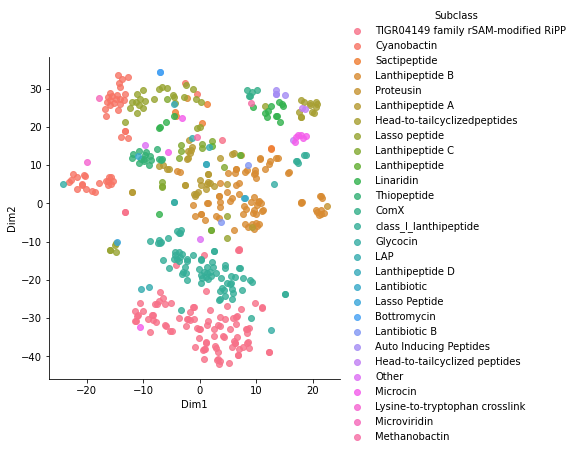

In [8]:
#Visualize the TSNE, coloring by Subclass
sns.lmplot(x="Dim1", y="Dim2", data=all_bact_X_embedded_df, hue="Subclass", fit_reg=False)